# Simulation settings

In [22]:
L = 22
J = 1
h = 0.05
lamb = 0.5

particle_pair_left_position = 10
particle_pair_length = 1

final_time = 5
layers = 50
measure_every_layers = 1

# Device selection

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance

channel = "ibm_quantum"
device = "ibm_kyiv"

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

# Circuit transpilation

In [23]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits

optimization_level = 2

# qubits_inds = None
qubits_inds = [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 
               3, 2, 1, 0, 14, 18, 19, 20, 21, 22, 
               23, 24, 25, 26, 27, 28, 29, 35, 47, 48, 
               49, 55, 68, 67, 66, 65, 64, 63, 62, 61, 
               60, 59, 58, 71, 77, 76]

physical_circuits = physical_particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, backend, optimization_level, qubits_inds, measure_every_layers=measure_every_layers)
print(f"Longest circuit contains {physical_circuits[-1].num_nonlocal_gates()} 2-qb gates")
physical_circuits[1].draw(output="mpl", idle_wires=False, fold=-1)

Longest circuit contains 4350 2-qb gates


# Estimator circuit execution

### Options

In [24]:
from utils.hexec import execdb

default_shots = 10000
optimization_level = 0 # Deactivate error suppression
resilience_level = 0 # Deactivate error mitigation
execution_database = "z2_chain_jobs.json"
zne_mitigation = "linear"
measure_mitigation = True
dynamical_decoupling = "XY4"
zne_mitigation_dict = {"none": "",
                       "linear": r"linear",
                       "quadratic": r'polynomial_degree_2',
                       "exponential": r"exponential"}

estimator_options = {
    "default_shots": default_shots,
    "optimization_level": optimization_level,
    "resilience_level": resilience_level,
    "resilience": {
        "zne_mitigation": bool(zne_mitigation_dict[zne_mitigation]),
        "measure_mitigation": measure_mitigation
    },
    "dynamical_decoupling": {
        "enable": bool(dynamical_decoupling),
        "sequence_type": dynamical_decoupling
    },
    "twirling": {
        "enable_gates": False,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
}

if bool(zne_mitigation_dict[zne_mitigation]):
    estimator_options["resilience"]["zne"] = {"extrapolator": zne_mitigation_dict[zne_mitigation]}

job_db = execdb(execution_database)

### Observables to measure

In [12]:
from z2chain.operators import local_pauli_z
from functools import partial

observable_name = "Occupation numbers"
observable_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]

### Send job to hardware

In [ ]:
jobs = job_db.execute_estimator_batch(backend, estimator_options, physical_circuits, observable_generating_funcs, observable_name)

### Load last job with the same options

In [6]:
jobs = job_db.search_by_params(estimator_options, physical_circuits, observable_name, strict_depth=False, limit=1, ibmq_service=service)

# Post-selected circuit execution

In [ ]:
from utils.hexec import execdb

default_shots = 8192
execution_database = "z2_chain_postselected_jobs.json"
dynamical_decoupling = "XY4"

sampler_options = {
    "default_shots": default_shots,
    "dynamical_decoupling": {
        "enable": bool(dynamical_decoupling),
        "sequence_type": dynamical_decoupling
    },
    "twirling": {
        "enable_gates": True,
        "num_randomizations": 32,
        "shots_per_randomization": 100
    }
}

job_db = execdb(execution_database)

# Plots

### Quech plot

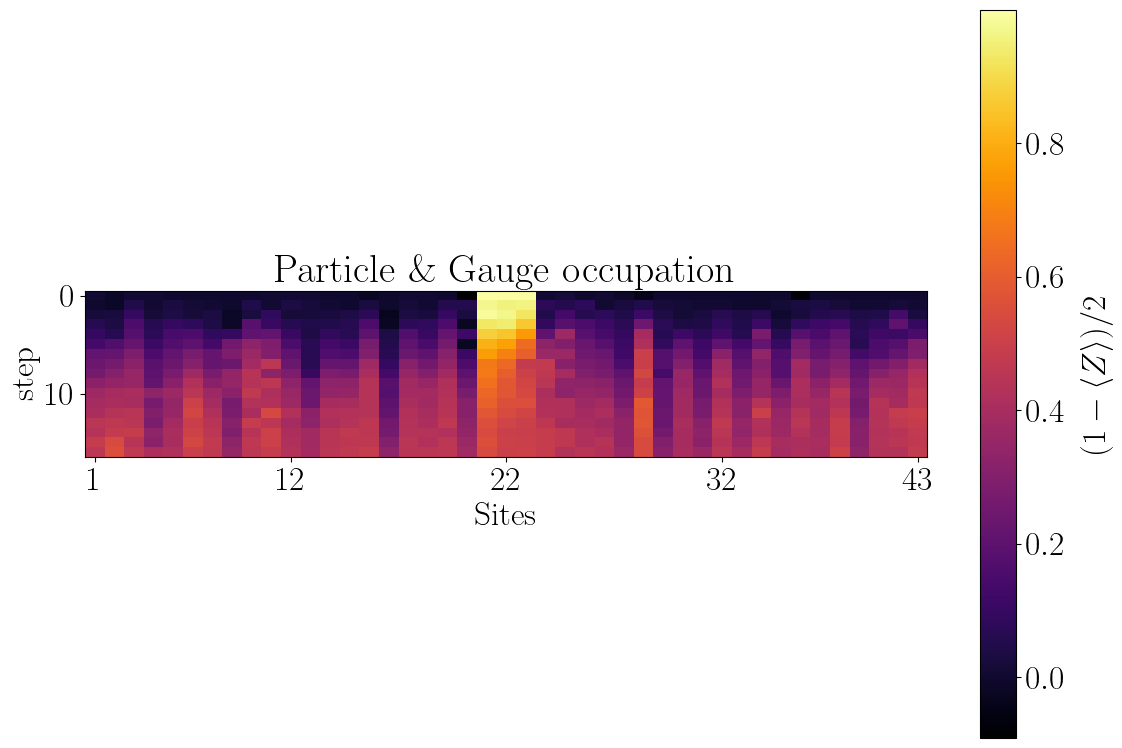

In [7]:
from z2chain.plotting import x_t_plot

x_t_plot(jobs, filepath=f"Plots/hardware_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_zne_{zne_mitigation}_mm_{measure_mitigation}_dc_{dynamical_decoupling}.png")

### Comparison with circuit tensor network simulation

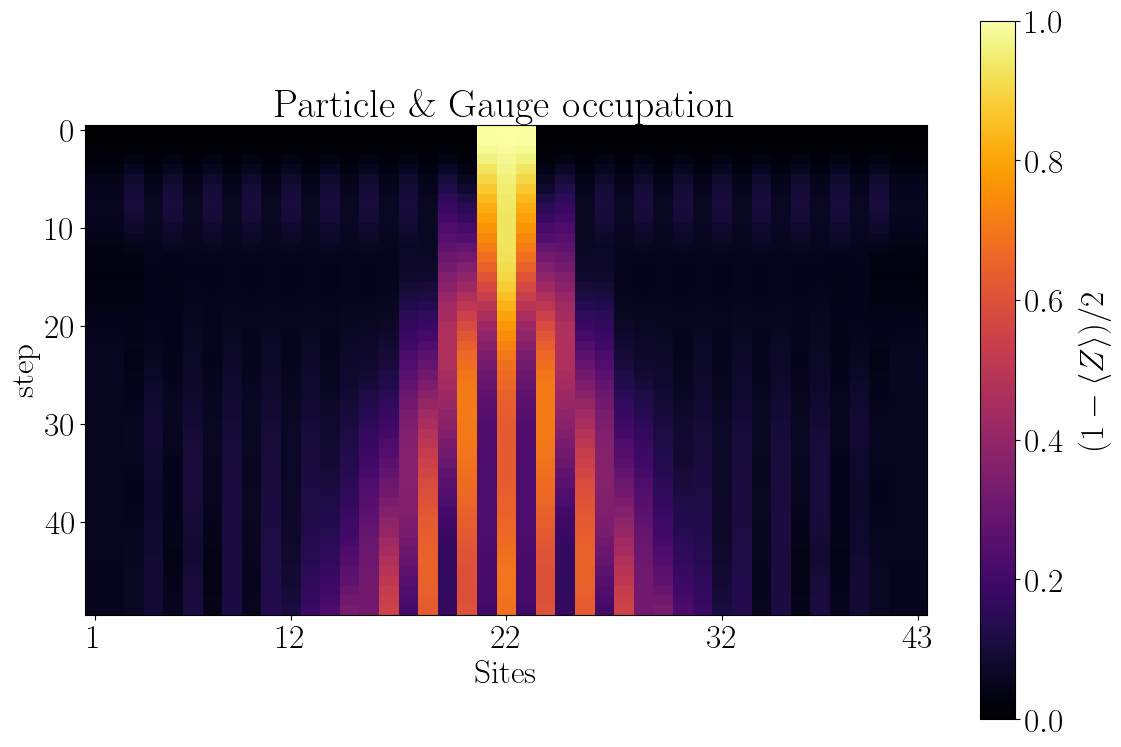

In [25]:
from z2chain.plotting import x_t_plot, save_site_gauge_observable_matrix, load_site_gauge_observable_matrix
from z2chain.circs import particle_pair_quench_simulation_circuits
from utils.sexec import execute_simulation_estimator_batch
import os

estimator_options = {
    "default_precision": 0
}

mps_simulator_options = {
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-8,
    "max_parallel_threads": 8,
    "max_parallel_experiments": 8
}

filepath = f"Results/tncirc_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_bd_{mps_simulator_options["matrix_product_state_max_bond_dimension"]}_prec_{estimator_options['default_precision']}.txt"

if os.path.exists(filepath):
    tn_site_gauge_observable_matrix = load_site_gauge_observable_matrix(filepath)
else:
    logical_circs = particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, measure_every_layers)
    observables_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]
    tn_site_gauge_observable_matrix = execute_simulation_estimator_batch(mps_simulator_options, estimator_options, logical_circs, observables_generating_funcs)
    save_site_gauge_observable_matrix(tn_site_gauge_observable_matrix, filepath)

x_t_plot(tn_site_gauge_observable_matrix, filepath=os.path.join("Plots", os.path.basename(os.path.split(filepath)[1])) + ".png")

In [ ]:
from z2chain.plotting import discrepancies_plot

discrepancies_plot(tn_site_gauge_observable_matrix, jobs)